In [11]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [13]:
Savee = "/content/drive/MyDrive/ALL"  # Note: removed the extra 'L' from 'ALLL'
print(f"Checking if path exists: {os.path.exists(Savee)}")
if os.path.exists(Savee):
    print(f"Files in directory: {len(os.listdir(Savee))}")
else:
    print("Path not found. Current directory contents:")
    print(os.listdir('/content/drive/MyDrive'))

Checking if path exists: True
Files in directory: 480


In [14]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Import required libraries
import pandas as pd
import numpy as np
import os
import librosa
import librosa.display
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
import tensorflow as tf

import warnings
warnings.filterwarnings("ignore")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [15]:
def extract_features(data, sr):
    # ZCR
    zcr = np.mean(librosa.feature.zero_crossing_rate(y=data))

    # MFCC (reduced coefficients)
    mfcc = np.mean(librosa.feature.mfcc(y=data, sr=sr, n_mfcc=13).T, axis=0)

    # RMS
    rms = np.mean(librosa.feature.rms(y=data))

    # Combine features
    features = np.hstack([zcr, mfcc, rms])
    return features

def get_features(path):
    # Load audio with reduced duration
    data, sr = librosa.load(path, duration=2.0)

    # Get original features
    features = extract_features(data, sr)

    return features

In [16]:
# Set the correct path to your dataset
Savee = "/content/drive/MyDrive/ALL"

def create_savee_df(data_path):
    file_emotion = []
    file_path = []

    for filename in os.listdir(data_path):
        if filename.endswith(".wav"):
            file_path.append(os.path.join(data_path, filename))
            part = filename.split('_')[1]
            ele = part[:-6]
            if ele=='a':
                file_emotion.append('angry')
            elif ele=='d':
                file_emotion.append('disgust')
            elif ele=='f':
                file_emotion.append('fear')
            elif ele=='h':
                file_emotion.append('happy')
            elif ele=='n':
                file_emotion.append('neutral')
            elif ele=='sa':
                file_emotion.append('sad')
            else:
                file_emotion.append('surprise')

    return pd.DataFrame({'Emotions': file_emotion, 'Path': file_path})

# Create dataframe and check data
df = create_savee_df(Savee)
print(f"Total number of files: {len(df)}")
print("\nEmotion distribution:")
print(df['Emotions'].value_counts())

Total number of files: 480

Emotion distribution:
Emotions
neutral     120
sad          60
disgust      60
happy        60
fear         60
surprise     60
angry        60
Name: count, dtype: int64


In [18]:
# Extract features
print("Extracting features...")
X = []
Y = df['Emotions'].values

for path in df['Path']:
    features = get_features(path)
    X.append(features)

X = np.array(X)
print(f"Features shape: {X.shape}")

# Encode labels
encoder = OneHotEncoder(sparse_output=False)  # Changed from sparse=False to sparse_output=False
Y = encoder.fit_transform(Y.reshape(-1, 1))

# Split data
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# Scale features
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

# Reshape for CNN
x_train = np.expand_dims(x_train, axis=2)
x_test = np.expand_dims(x_test, axis=2)

print("Data preparation completed!")

Extracting features...
Features shape: (480, 15)
Data preparation completed!


In [19]:
# Create model
model = tf.keras.Sequential([
    tf.keras.layers.Conv1D(64, 3, activation='relu', input_shape=(x_train.shape[1], 1)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling1D(2),

    tf.keras.layers.Conv1D(128, 3, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling1D(2),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(y_train.shape[1], activation='softmax')
])

# Compile model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Train model
history = model.fit(
    x_train, y_train,
    batch_size=32,
    epochs=50,
    validation_split=0.2,
    verbose=1
)

Epoch 1/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 9s 45ms/step - accuracy: 0.2074 - loss: 2.4418 - val_accuracy: 0.2727 - val_loss: 1.8654
Epoch 2/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5678 - loss: 1.1674 - val_accuracy: 0.4026 - val_loss: 1.8500
Epoch 3/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.6489 - loss: 0.9386 - val_accuracy: 0.4026 - val_loss: 1.8429
Epoch 4/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.7262 - loss: 0.7324 - val_accuracy: 0.2987 - val_loss: 1.8444
Epoch 5/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8044 - loss: 0.6116 - val_accuracy: 0.2987 - val_loss: 1.8361
Epoch 6/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.8458 - loss: 0.5363 - val_accuracy: 0.3117 - val_loss: 1.8321
Epoch 7/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.8811 - loss: 0.4566 - val_accuracy: 0.2727 - val_loss: 1.8294
Epoch 8/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.8918 - loss: 0.3601 - val_accuracy: 0.2338 - v

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.5286 - loss: 1.5739 

Test accuracy: 54.17%
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step 

Classification Report:
              precision    recall  f1-score   support

       angry       0.62      0.57      0.59        14
     disgust       0.31      0.31      0.31        13
        fear       0.64      0.47      0.54        15
       happy       0.36      0.31      0.33        13
     neutral       0.74      0.83      0.78        24
         sad       0.33      0.50      0.40         6
    surprise       0.50      0.55      0.52        11

    accuracy                           0.54        96
   macro avg       0.50      0.50      0.50        96
weighted avg       0.54      0.54      0.54        96



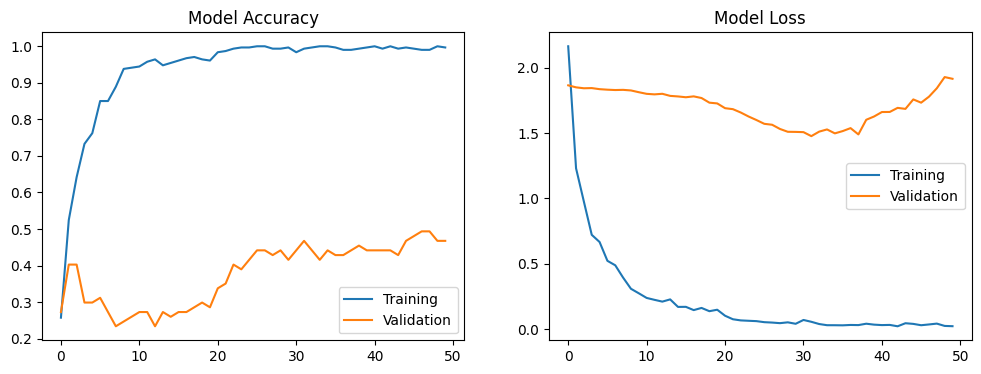

In [20]:
# Evaluate
test_loss, test_accuracy = model.evaluate(x_test, y_test)
print(f"\nTest accuracy: {test_accuracy*100:.2f}%")

# Predictions
y_pred = model.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_classes = np.argmax(y_test, axis=1)

# Print classification report
print("\nClassification Report:")
print(classification_report(y_test_classes, y_pred_classes,
                          target_names=encoder.categories_[0]))

# Plot results
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.title('Model Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training')
plt.plot(history.history['val_loss'], label='Validation')
plt.title('Model Loss')
plt.legend()
plt.show()

Training Accuracy: 89.32%
Testing Accuracy: 54.17%
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 

Detailed Classification Report:
              precision    recall  f1-score   support

       angry       0.62      0.57      0.59        14
     disgust       0.31      0.31      0.31        13
        fear       0.64      0.47      0.54        15
       happy       0.36      0.31      0.33        13
     neutral       0.74      0.83      0.78        24
         sad       0.33      0.50      0.40         6
    surprise       0.50      0.55      0.52        11

    accuracy                           0.54        96
   macro avg       0.50      0.50      0.50        96
weighted avg       0.54      0.54      0.54        96



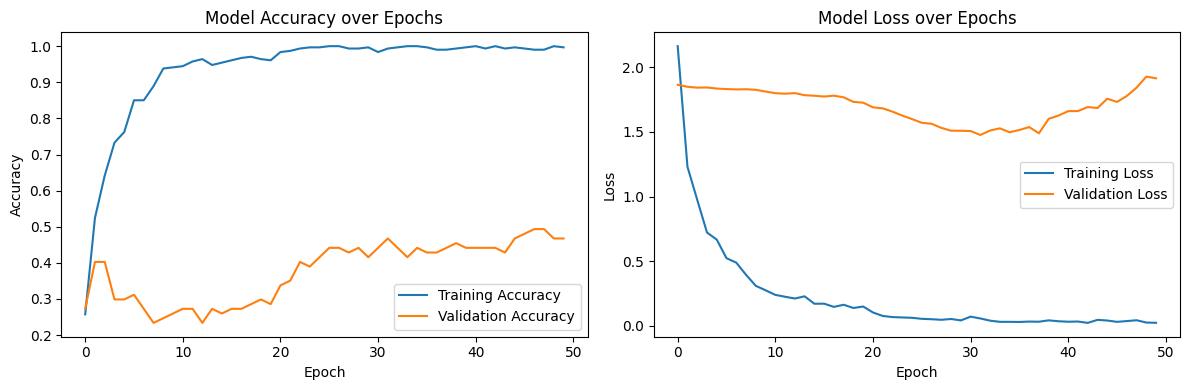

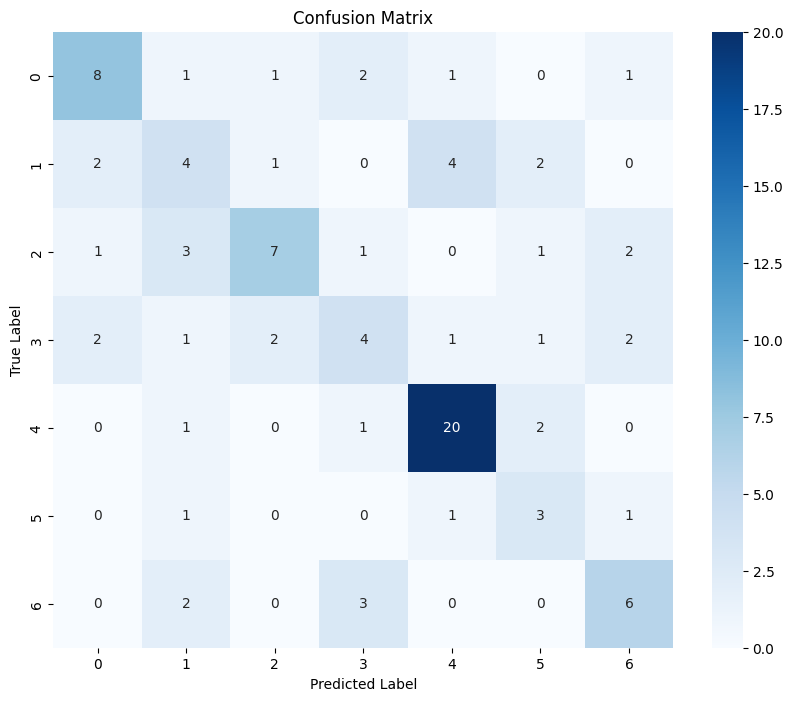

In [22]:
# Training Accuracy
train_loss, train_accuracy = model.evaluate(x_train, y_train, verbose=0)
print(f"Training Accuracy: {train_accuracy*100:.2f}%")

# Testing Accuracy
test_loss, test_accuracy = model.evaluate(x_test, y_test, verbose=0)
print(f"Testing Accuracy: {test_accuracy*100:.2f}%")

# Detailed Classification Report
y_pred = model.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_classes = np.argmax(y_test, axis=1)

print("\nDetailed Classification Report:")
print(classification_report(y_test_classes, y_pred_classes,
                          target_names=encoder.categories_[0]))

# Plot Training History
plt.figure(figsize=(12, 4))

# Plot Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

# Plot Confusion Matrix
cm = confusion_matrix(y_test_classes, y_pred_classes)
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()